# Analysis of Bike Share Toronto Usage
## Report 1: General Ridership Trends

### By Chris Kimber
### With Amanda Xuereb and Andy Wong
### August 8, 2023

In [16]:
# This option is used to suppress warnings in the report output
# DO NOT USE this option when working on analysis, ONLY for clean reporting
options(warn = -1)

In [2]:
# Package Loading
library(tidyverse)
library(lubridate)
library(wesanderson)
library(scales)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────

In [3]:
# Custom theme used for plotting in this notebook series
theme_bikeshare <- function(){
    font <- "Helvetica"
    
    theme_linedraw() %+replace%
    
    theme(
        
        # grid elements
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        
        # legend elements
        legend.position = "bottom",
        
        # text elements
        plot.title = element_text(
                    family = font,
                    size = 20,
                    face = "bold",
                    hjust = 0,
                    vjust = 2),
        
        plot.subtitle = element_text(
                    family = font,
                    size = 14),
        
        axis.title = element_text(
                    family = font,
                    size = 14),
        
        axis.title.x = element_text(
                    margin = margin(t = 5)),
        
        axis.title.y = element_text(
                    margin = margin(r = 10),
                    angle = 90),
        
        axis.text = element_text(
                    family = font,
                    size = 12),
        
        axis.text.x = element_text(
                    margin = margin(t = 5))
    )
}

In [4]:
# This theme is derived from the main theme
# Adds options for faceted plots only (particularly the use of plot borders)
theme_bikefacets <- function(){
    font <- "Helvetica"
    
    theme_linedraw() %+replace%
    
    theme(
        
        # grid elements
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        
        # legend elements
        legend.position = "bottom",
        
        # text elements
        plot.title = element_text(
                    family = font,
                    size = 20,
                    face = "bold",
                    hjust = 0,
                    vjust = 2),
        
        plot.subtitle = element_text(
                    family = font,
                    size = 14),
        
        axis.title = element_text(
                    family = font,
                    size = 14),
        
        axis.title.x = element_text(
                    margin = margin(t = 5)),
        
        axis.title.y = element_text(
                    margin = margin(r = 10),
                    angle = 90),
        
        axis.text = element_text(
                    family = font,
                    size = 12),
        
        axis.text.x = element_text(
                    margin = margin(t = 5)),
        
        # strip elements
        
        strip.background = element_rect(
                            fill = "royalblue4"),
        
        strip.text = element_text(
                    family = font,
                    size = 14,
                    face = "bold",
                    colour = "white")
    )
}

In [5]:
# Load palette from the "wesanderson" colour palette pack for R
zis_colours <- wes_palette("Zissou1", type = "discrete")

In [3]:
# Load preprocessed dataset (see ./Data Processing/data_loading.ipynb)
data_all_years <- read_csv("../Data/data_all_years.csv")

Rows: 16961551 Columns: 10
── Column specification ──────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Start.Station.Name, End.Station.Name, User.Type
dbl  (5): Trip.Id, Trip.Duration, Start.Station.Id, End.Station.Id, Bike.Id
dttm (2): Start.Time, End.Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Introduction 

Bike-sharing systems, both public and private, are an increasingly common part of the urban public transportation landscape. As one of the major metropolitan areas in North America, Toronto is no exception. Bike Share Toronto was originally founded as a private enterprise in 2011 before being taken over by the city itself in 2014. Its status as a publicly managed transit service means the City of Toronto has made a reasonable share of Bike Share Toronto’s ridership data public through the city’s Open Data Portal (https://open.toronto.ca/). This is the first in a series of reports illustrating how riders use Bike Share Toronto, and the ways that usage has changed over the COVID-19 pandemic.

## A Quick Word on Data

In this report, we chose to limit our analysis to the years 2017-2022. While older data is available from the City of Toronto, the data provider changed during 2016. This time period provides a window into ridership before, during the peak of, and in the aftermath of the COVID-19 pandemic. It also spans a significant period of growth in the Bike Share Toronto network, with the first major network expansion having taken place in 2016 and continued rounds of expansion occurring in each subsequent year.  Details on data ingestion and pre-processing can be found at (INSERT LINK).

##  User Types

A fundamental part of the Bike Share Toronto pricing model is the existence of two main user types. While the details of pricing structures have shifted over the period we analyzed, the basics of user types remained constant. 

* **Annual** members are those who pay for a subscription to the service for the year and are allowed unlimited rides within certain restrictions. 
* **Casual** members are those who use the system on an ad hoc basis, paying for an individual ride or short period pass. 

Given the nature of the pricing structure, we expect that Annual members will principally be commuters or riders who use the service for regular errands. Casual users, in contrast, will often be tourists or recreational users taking rides for fun or convenience. These user types are of particular interest for a number of reasons. The city may logically view Casual use as an entry point to the system for riders that can then be converted to the consistent income of Annual members. In addition, we can expect each user type to have experienced the effects of the COVID-19 pandemic in distinct ways.

## Year-on-Year Growth

Bike Share Toronto has shown consistent growth in ridership over the 6-year period we analyzed (Fig.1). Indeed, ridership has increased every year despite the dramatic upheaval to society represented by the COVID-19 pandemic beginning in March 2020. This is important, as it shows that the use of the service is robust to fundamental decreases in both the need for office commuter rides and the volume of tourists visiting the city.

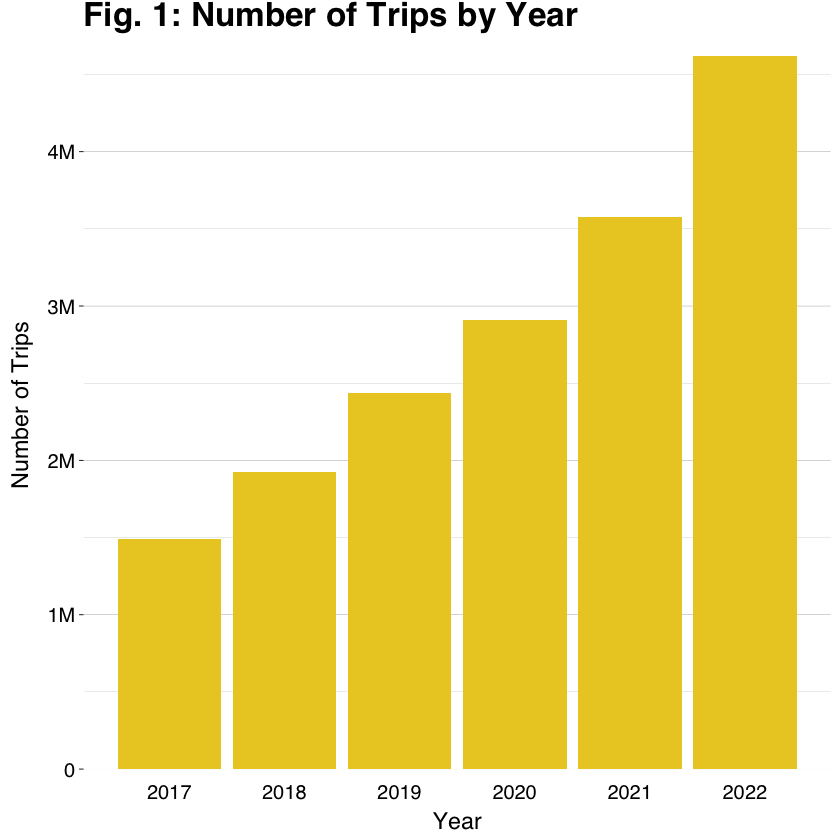

In [7]:
options(repr.plot.width = 7, repr.plot.height = 7)

data_all_years %>% count(year = year(Start.Time)) %>%
    ggplot(aes(x = year, y = n)) + geom_bar(fill = zis_colours[3], stat = "identity") +
        labs(title = "Fig. 1: Number of Trips by Year",
            x = "Year",
            y = "Number of Trips") +
        scale_x_continuous(breaks = seq(2017, 2022, 1)) +
        scale_y_continuous(expand = expansion(add = c(0,100000)), labels = label_number_si()) +
        theme_bikeshare()

The relative year-on-year (YOY) growth in the use of the service was lowest in 2020 (Fig. 2), which likely reflects the impact of the strongest pandemic restrictions. That said, the YOY difference between 2020 and adjacent years is rather small, and a growth rate of nearly 20% in the face of the pandemic shows the service remained a popular option for riders exploring their ‘new’ lifestyles.

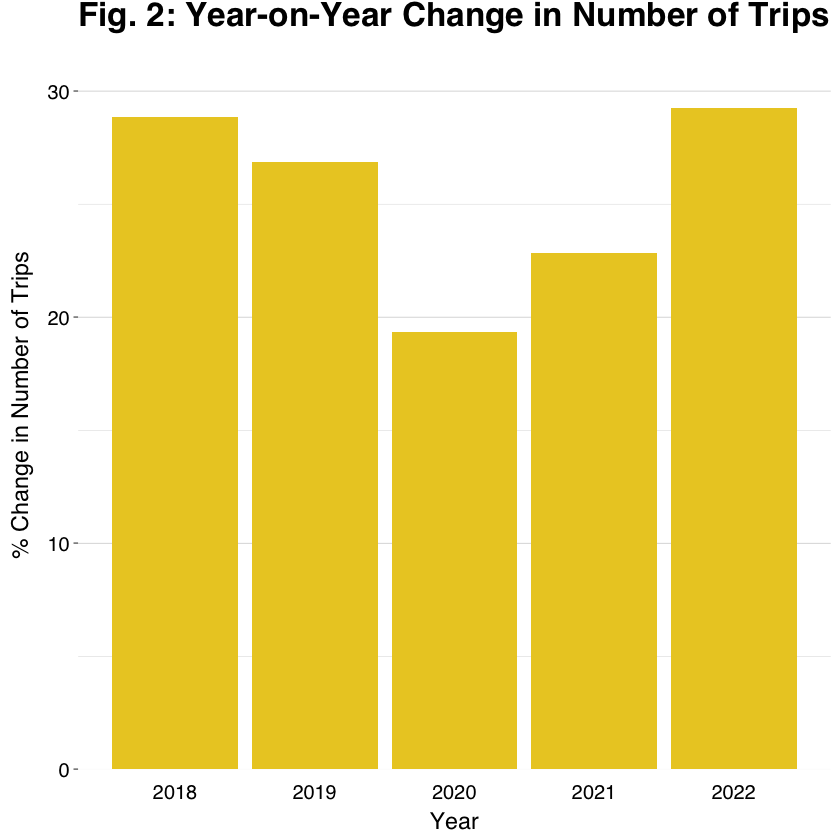

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7)

data_all_years %>% count(year = year(Start.Time)) %>% mutate(perc_change = ((n - lag(n))/lag(n))*100) %>%
    ggplot(aes(x = year, y = perc_change)) + geom_bar(fill = zis_colours[3], stat = "identity") +
        labs(title = "Fig. 2: Year-on-Year Change in Number of Trips",
            x = "Year",
            y = "% Change in Number of Trips") +
            scale_y_continuous(expand = expansion(add = c(0,3))) +
            theme_bikeshare()

It is worth mentioning briefly that our metric for ridership is the number of unique rides taken on the system (i.e., each time a bike is checked out for a ride) rather than unique users. While we believe both metrics are important for assessing the system’s popularity, the City of Toronto does not provide any data on user identification (even anonymized) in the Open Data Portal.

## Usage Shifts During Growth

The YOY increase in ridership is particularly noticeable during the summer months (Fig. 3), which is consistent with an increase in users who are not simply relying on the bikes for their commute (which will be stable whenever weather allows for riding). While the growth between 2020 and 2021 occurred largely in spring, likely because of acute pandemic effects resulting in depressed ridership in spring 2020, ridership grew strongly in the warmer months of 2022 compared to 2021 and growth continued into the cooler months as well (Fig. 4).

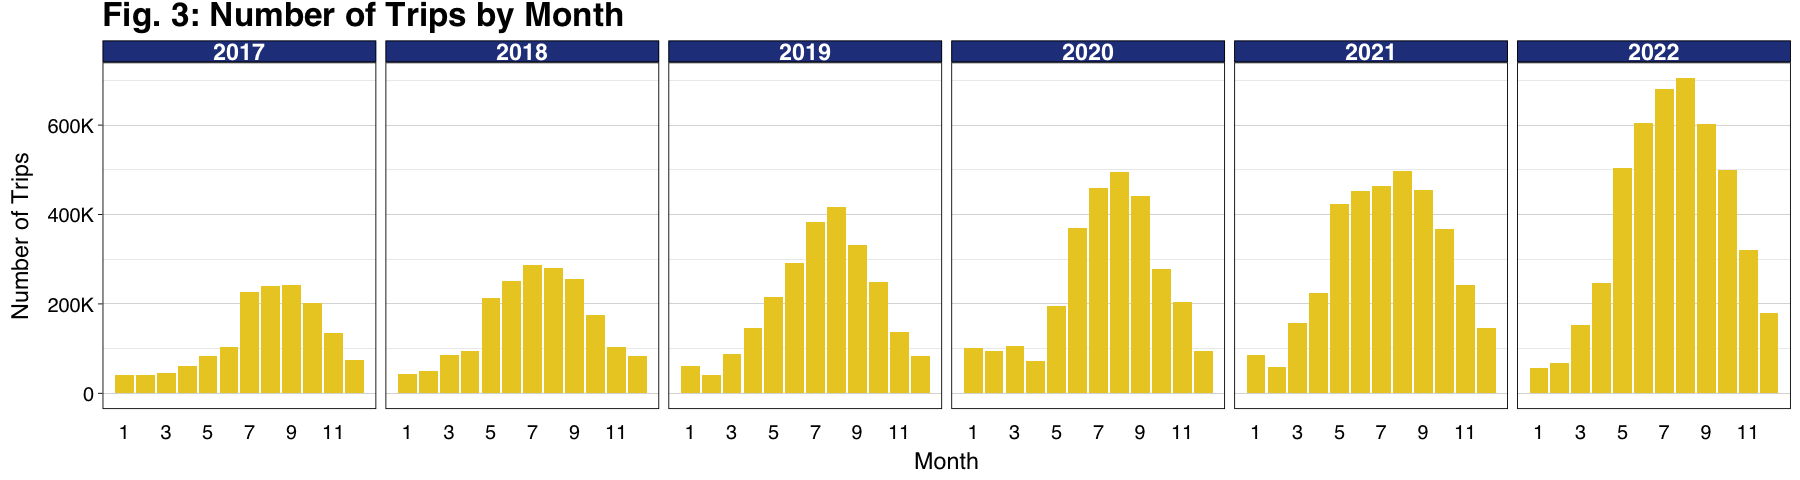

In [9]:
options(repr.plot.width = 15, repr.plot.height = 4)

data_all_years %>% group_by(year = year(Start.Time)) %>% count(month = month(Start.Time)) %>%
    ggplot(aes(x = month, y = n)) + geom_bar(fill = zis_colours[3], stat = "identity") +
        labs(title = "Fig. 3: Number of Trips by Month",
            x = "Month",
            y = "Number of Trips") +
        scale_x_continuous(breaks = seq(1,12,2)) +
        scale_y_continuous(labels = label_number_si()) +
        facet_wrap(~year, nrow = 1) +
        theme_bikefacets()

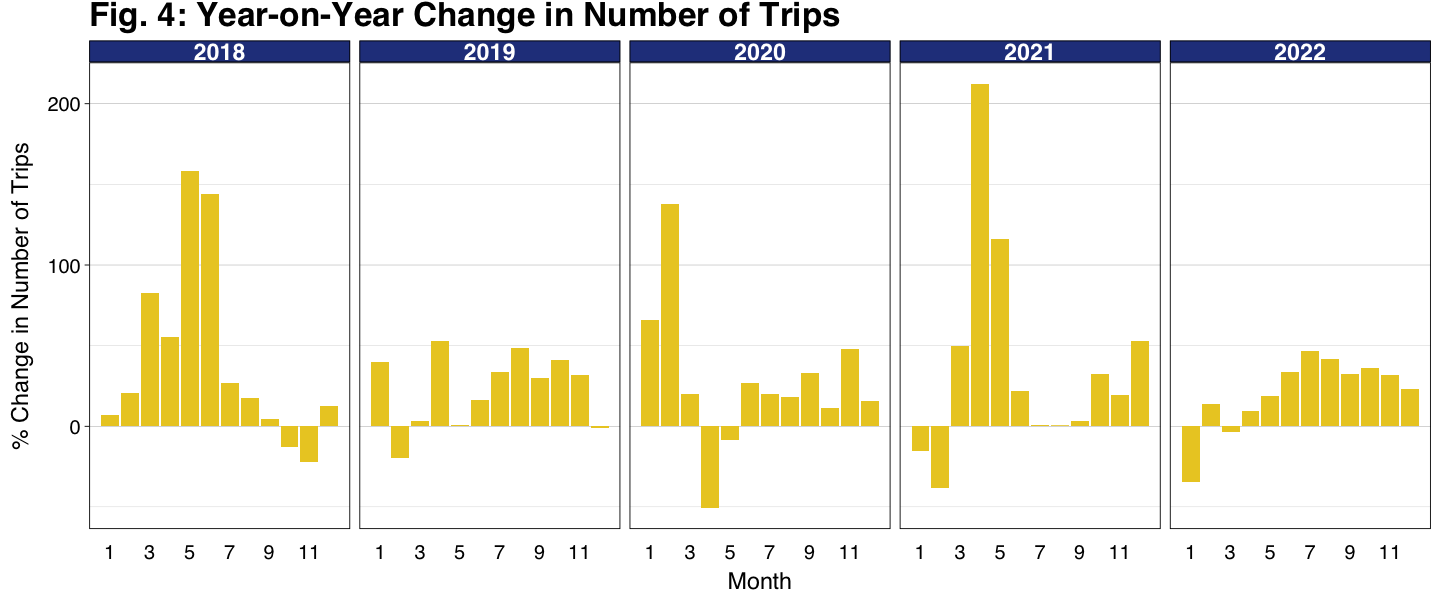

In [10]:
options(repr.plot.width = 12, repr.plot.height = 5)

data_all_years %>% group_by(year = year(Start.Time)) %>% count(month = month(Start.Time)) %>%
    group_by(month) %>% mutate(perc_change = ((n-lag(n))/lag(n))*100) %>% filter(year > "2017") %>%
         ggplot(aes(x = month, y = perc_change)) + geom_bar(fill = zis_colours[3], stat = "identity") +
            labs(title = "Fig. 4: Year-on-Year Change in Number of Trips",
                x = "Month",
                y = "% Change in Number of Trips") +
            scale_x_continuous(breaks = seq(1,12,2)) +
            facet_wrap(~year, nrow = 1) +
            theme_bikefacets()

Ridership was increasing over the 6 years we investigated, but not equally for each user type (Fig. 5). There was a strong growth in ridership for Casual members across the period (Fig. 6). Uptake grew during the height of the pandemic, which likely reflects new or returning users taking advantage of the safety and convenience of outdoor activities or because other travel opportunities were limited. Casual ridership grew even more strongly in 2022, with over 60% of all trips made by Casual riders (Fig. 7), which is probably encouraging for the system as it means the increased use during the pandemic has outlasted the restrictions and/or been augmented by the return of long distance tourism.

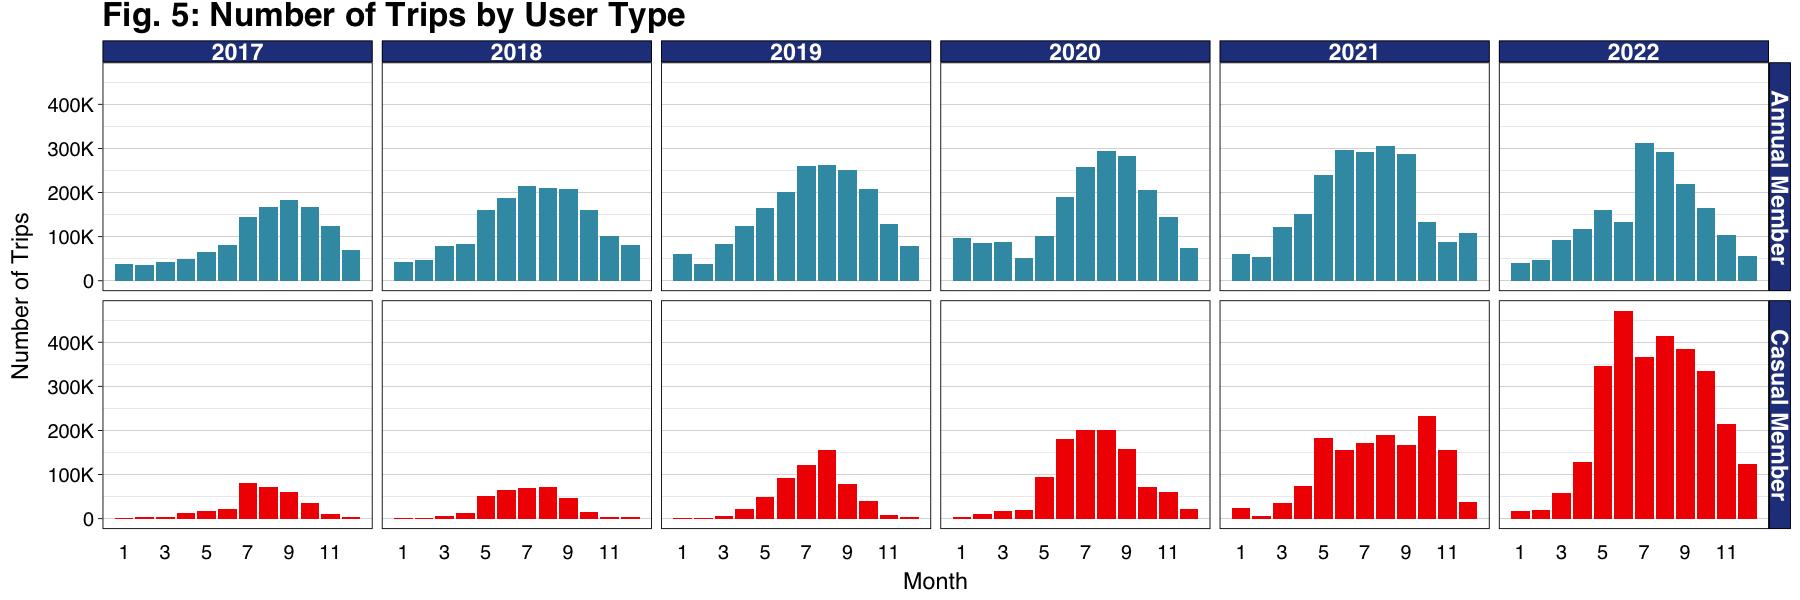

In [11]:
options(repr.plot.width = 15, repr.plot.height = 5)

data_all_years %>% group_by(year = year(Start.Time), User.Type) %>% count(month = month(Start.Time)) %>%
    ggplot(aes(x = month, y = n)) + geom_bar(aes(fill = User.Type), stat = "identity") +
        labs(title = "Fig. 5: Number of Trips by User Type",
            x = "Month",
            y = "Number of Trips") +
        scale_fill_manual(values = c(zis_colours[1], zis_colours[5])) +
        scale_x_continuous(breaks = seq(1,12,2)) + 
        scale_y_continuous(labels = label_number_si()) +
        facet_grid(User.Type ~ year) +
        theme_bikefacets() +
        guides(fill = "none")

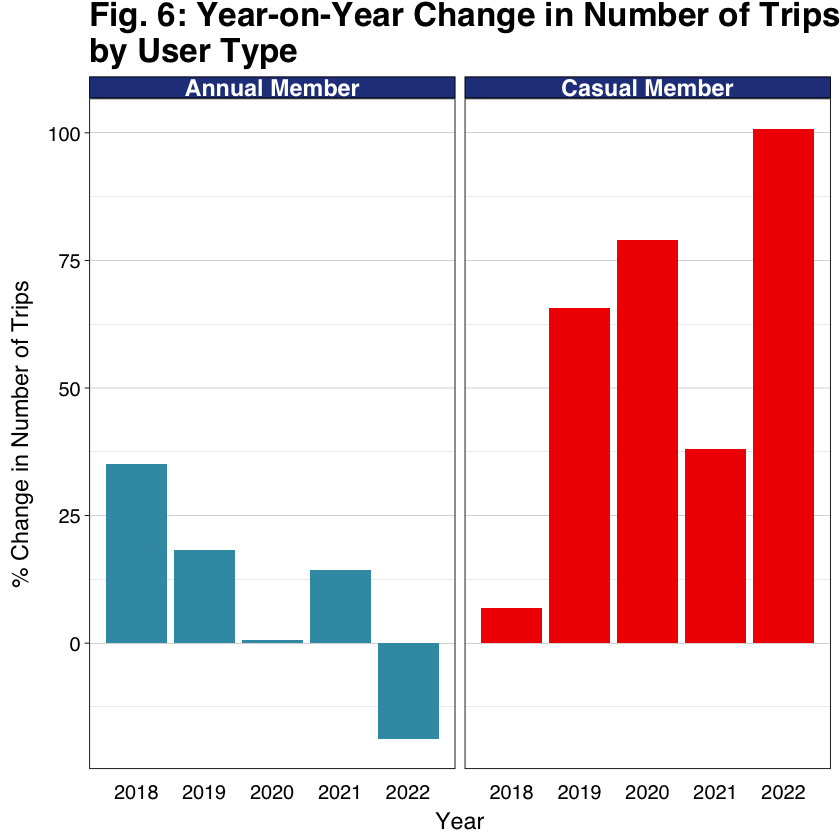

In [12]:
options(repr.plot.width = 7, repr.plot.height = 7)

data_all_years %>% count(year = year(Start.Time), User.Type) %>% group_by(User.Type) %>%
    mutate(perc_change = ((n - lag(n))/lag(n))*100) %>%
        ggplot(aes(x = year, y = perc_change)) + geom_bar(aes(fill = User.Type), stat = "identity") +
        labs(title = "Fig. 6: Year-on-Year Change in Number of Trips \nby User Type",
            x = "Year",
            y = "% Change in Number of Trips") +
        scale_fill_manual(values = c(zis_colours[1], zis_colours[5])) +
        facet_wrap(~User.Type) +
        theme_bikefacets() +
        guides(fill = "none")

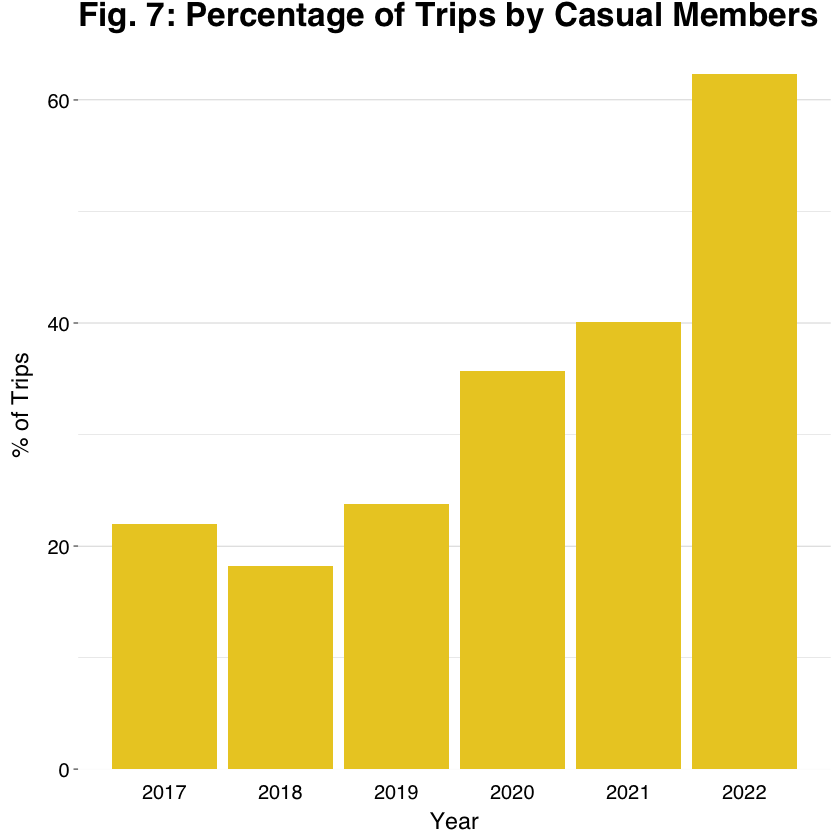

In [15]:
options(repr.plot.width = 7, repr.plot.height = 7)

suppressMessages(
data_all_years %>% count(year = year(Start.Time), User.Type) %>% group_by(year) %>%
    pivot_wider(names_from = User.Type, values_from = n, names_repair = "universal") %>%
    mutate(perc_cas = (Casual.Member/(Annual.Member + Casual.Member))*100) %>%
        ggplot(aes(x = year, y = perc_cas)) + geom_bar(fill = zis_colours[3], stat = "identity") +
            labs(title = "Fig. 7: Percentage of Trips by Casual Members",
                x = "Year",
                y = "% of Trips") +
            scale_x_continuous(breaks = seq(2017,2022,1)) +
            scale_y_continuous(expand = expansion(add = c(0,3))) +
            theme_bikeshare()
)

In contrast, Annual ridership patterns were fairly constant from 2019-2022 (Fig. 6), which is notable, as the complete shift in the logistics of commuting during 2020 did not result in decreased use by what we assume to be a commuter-dominated user type. What is striking is that Annual ridership actually fell off in 2022. This may suggest that while regular commuters found other ways to use the service during the height of the pandemic, this type of use was not sustained during the return towards ‘normalcy’ in many aspects of life. 

This shift may pose a challenge for Bike Share Toronto, as Annual users provide a consistent source of income for the year. While the income loss may be compensated for at this point by the increased Casual ridership, the dependability of Annual members should not be discounted. We note, however, that we are unable to ascertain whether reduced Annual ridership is due to fewer Annual members as we lack access to user-specific data.

## Trip Durations 

The Bike Share Toronto pricing model has a significant impact on the duration of rides, perhaps more than the density of stations or the needs of riders. Annual users are allowed unlimited rides of 30 minutes or less (with a 45 minute package available from April 2021). If users wish to take a longer trip, they must exchange bikes at a station to continue their ride. The payment plans for Casual riders have varied, but until spring 2023 they were also limited to 30-minute rides at a time. Pay-as-you-go packages are now becoming more widely available.

On the whole, Annual users take shorter rides than Casual users (Fig. 8). We present trimmed-mean trip durations here because of the presence of extreme outlier rides for Casual users in particular. Casual users are more likely to record extremely long trips, as they may be less familiar with the system and more likely to fail to return a bike correctly or know how to properly address any failure that prevents the ride from terminating. Ignoring these outliers, it is likely that Annual users still tend to take shorter rides because they are more familiar with the stations on their typical commutes and know where to change bikes efficiently during their journeys in order to minimize the chances of running over the time limit.

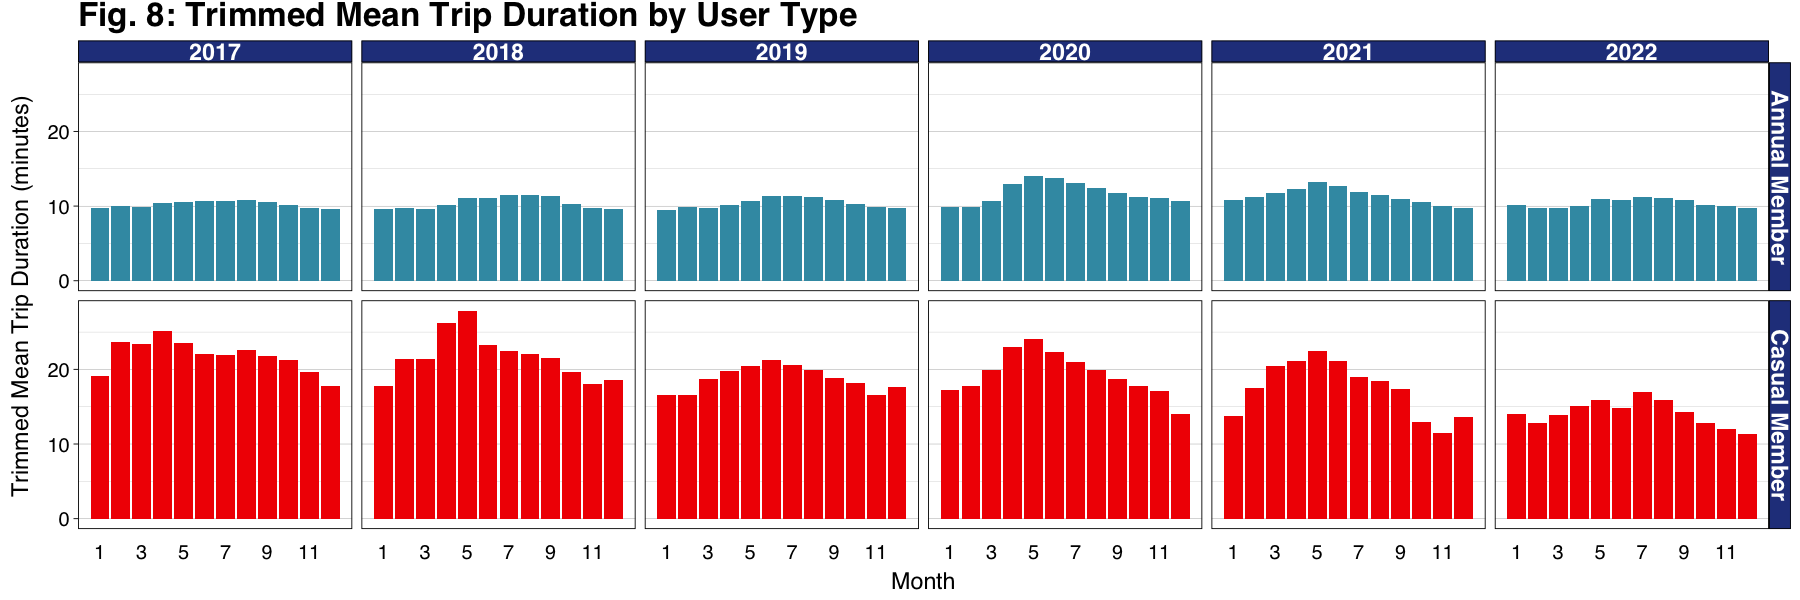

In [14]:
options(repr.plot.width = 15, repr.plot.height = 5)

data_all_years %>% filter(Trip.Duration != 0) %>%
    group_by(year = year(Start.Time), month = month(Start.Time), User.Type) %>%
    summarize(mean = mean(Trip.Duration, trim = 0.1, na.rm = TRUE)/60, .groups = "keep") %>%
        ggplot(aes(x = month, y = mean)) + geom_bar(aes(fill = User.Type), stat = "identity") +
            labs(title = "Fig. 8: Trimmed Mean Trip Duration by User Type",
                x = "Month",
                y = "Trimmed Mean Trip Duration (minutes)") +
            scale_x_continuous(breaks = seq(1,12,2)) +
            scale_fill_manual(values = c(zis_colours[1], zis_colours[5])) +
            facet_grid(User.Type ~ year) +
            theme_bikefacets() +
            guides(fill = "none")

The mean ride duration of Annual members has remained extremely stable across the 6 years we investigated. There was a slight increase in duration during the warm months of 2020 and 2021 in particular, which may reflect Annual users making use of the system in different, perhaps more recreational ways while not commuting during the pandemic. There is also no evidence that the introduction of the 45 minute ride member package has resulted in longer average rides for Annual users, though our data does not allow us to segment these members and their rides.

Casual members have taken progressively shorter rides over the years on average, particularly in 2021 and 2022. The reasons behind this shift are not readily apparent. Duration for Casual users was fairly similar between 2019 and 2020, other than a spike during the warm months of the latter when the pandemic restrictions had just been implemented. It is possible that the recruitment of many new riders since 2020 includes those who now use the service for irregular short commuting or errands, but this hypothesis needs further analysis to investigate what types of rides Casual users have been making in the last two years.

## Conclusions

The overall performance of Bike Share Toronto over the last 6 years has been overwhelmingly positive. This is encouraging for any form of public transit infrastructure, but particularly so in light of the unprecedented upheaval in the basic rhythms of urban life produced by COVID-19 during that period. It also stands in stark contrast to the performance of traditional public transit in Toronto during that period. Toronto Transit Corporation ridership during 2020 and 2021 was less than 50% that of 2019, and recovery has been slow with 2022 ridership only reaching about 60% of pre-pandemic levels (Toronto Transit Corporation Operating Statistics). Beyond the increase in overall ridership each year, the shift towards Casual members rather than Annual members suggests the service has been relatively successful at attracting a user base beyond regular commuters. The emergence of pay-as-you-go plans in 2023 may further increase the appeal to this type of user. In contrast, decreasing use of the system by Annual members may suggest regular commuters have abandoned the service during the pandemic in a similar fashion to regular transit, likely as a result of a transition to remote work. The ability of Bike Share Toronto to re-attract these users, or replace them with more Casual users, will determine the longer-term fate of the system. 

In forthcoming reports in this series we will aim to integrate spatial data to better assess how use of the system changed during the pandemic, with an intention to understand what type of rides and riders are becoming more or less frequent and how Bike Share Toronto can best accommodate the maximum number of possible users.